In [49]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

In [2]:
n_epochs = 50         #number of epochs of training
batch_size = 64       #size of the batches
lr = 0.0002           #adam: learning rate
b1 = 0.5              #adam: decay of first order momentum of gradient
b2 = 0.999            #adam: decay of second order momentum of gradient
n_cpu = 8,            #number of cpu threads to use during batch generation
latent_dim = 100      #dimensionality of the latent space
img_size = 28         #size of each image dimension
channels = 1          #number of image channels
sample_interval = 400 #interval between image samples

img_shape = (channels, img_size, img_size)

cuda = True if torch.cuda.is_available() else False

random_seed = 1
torch.manual_seed(random_seed)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# Load Data

In [7]:
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "D:\PatternRecognition_Data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

# Training

In [46]:
def train_loop(
    generator: nn.Module, 
    discriminator: nn.Module, 
    g_optim: Optimizer, 
    d_optim: Optimizer,
    latent_dim,
    max_iter=100,
    cuda=True
    ):
    if cuda:
        generator, discriminator = generator.cuda(), discriminator.cuda()
    criterion = nn.BCELoss()
    g_losses, d_losses = [], []
    for epoch in range(max_iter):
        for i, (imgs, _) in enumerate(dataloader):
            # Configure input
            real_imgs = imgs
            batch_size_internal = real_imgs.shape[0]
            # Adversarial ground truths
            # We use the Cross Entropy (CE) loss. So we need labels:
            ones_labels = torch.ones([batch_size_internal,1])
            zeros_labels = torch.zeros([batch_size_internal,1])
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_() # sample z from a standard gaussian
            if cuda:
                real_imgs = real_imgs.cuda()
                z = z.cuda()
                ones_labels, zeros_labels = ones_labels.cuda(), zeros_labels.cuda()
            
            # -----------------
            #  Train Generator
            # -----------------
            generator.train()
            discriminator.eval()
            g_optim.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)# create generated images

            # Loss measures generator's ability to fool the discriminator
            g_loss = criterion(discriminator(gen_imgs), ones_labels)

            g_loss.backward()
            g_optim.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------
            generator.eval()
            discriminator.train()
            d_optim.zero_grad()
            
            # Sample noise as generator input
            z = torch.FloatTensor(batch_size_internal, latent_dim).normal_() # sample z from a standard gaussian
            if cuda:
                z = z.cuda()
            gen_imgs = generator(z)
            # Measure discriminator's ability to classify real from generated samples
            real_loss = criterion(discriminator(real_imgs), ones_labels)
            fake_loss = criterion(discriminator(gen_imgs), zeros_labels)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            d_optim.step()
            
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())
            
            if i%50 == 0:
                  print(
                  "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %.6f] [G loss: %.6f]"
                  % (epoch+1, max_iter, i, len(dataloader), d_loss.item(), g_loss.item()), end='\r'
            )

            batches_done = epoch * len(dataloader) + i
    #         if batches_done % sample_interval == 0:
    #             # You can also safe samples in your drive & maybe save your network as well
    #             save_image(gen_imgs.data[:25], "images/GAN-%d.png" % batches_done, nrow=5, normalize=True)
    print()
    return g_losses, d_losses

# Run Training

In [6]:
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Optimizers
g_optim = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
d_optim = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [47]:
g_losses, d_losses = train_loop(generator, discriminator, g_optim, d_optim, 
                                max_iter=10, latent_dim=latent_dim, cuda=True)

[Epoch 10/10] [Batch 900/938] [D loss: 0.3993] [G loss: 1.3042]


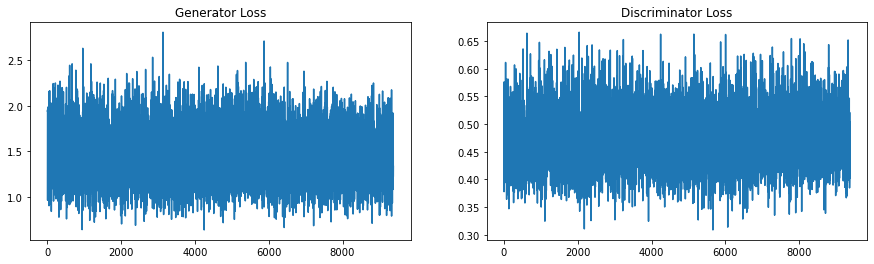

In [50]:
fig = plt.figure(figsize=(15, 4))
columns = 2
rows = 1
counter = 0
for losses, titles in zip([g_losses, d_losses],["Generator Loss", "Discriminator Loss"]):
    fig.add_subplot(rows, columns, counter+1)
    plt.plot(losses)
    plt.title(titles)
    counter += 1
plt.show()

# Generate some Images

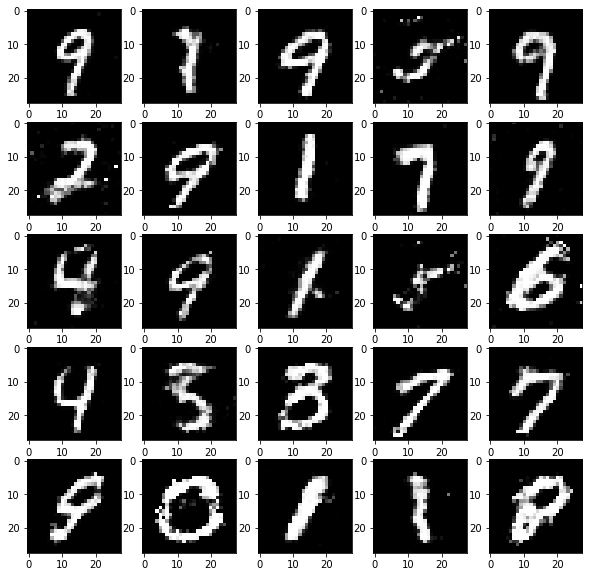

In [54]:
n = 25
z = torch.FloatTensor(n, latent_dim).normal_()
z = z.cuda()
sampled = generator(z)

fig = plt.figure(figsize=(10, 10))
columns = 5
rows = 5
counter = 0
for img in sampled:
    img_new = img[0].detach().cpu().numpy()
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img_new, cmap="gray")
    counter += 1
plt.show()